In [712]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

In [713]:
# read data
df = pd.read_csv('Cancer_Data.csv')
df

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,NaN
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,NaN
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,NaN
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,NaN


In [714]:
# check for missing values
df.isna().sum()

id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed:

In [715]:
# count the number of benign and malignant diagnoses
total_m = 0
for diagnosis in df['diagnosis']:
    if diagnosis == 'M':
        total_m += 1

total_b = 569 - total_m
print(f'Number of malignant: {total_m}, number of benign: {total_b}')

Number of malignant: 212, number of benign: 357


In [716]:
# split into X and y sections
X = df.iloc[:, 2:19].values
y = df.iloc[:, [1]].values #.reshape(len(y))

In [717]:
# encode binary classes 'M' and 'B'into integers
encoder = LabelEncoder()
encoder.fit(y.ravel())
y = encoder.transform(y.ravel())
print(encoder.classes_)

['B' 'M']


In [718]:
# create 2d torch tensors
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()
y = y.unsqueeze(1)

In [719]:
# # split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2)

In [720]:
# check dimensions
print(f'X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}')

X_train: torch.Size([455, 17]), y_train: torch.Size([455, 1]), X_test: torch.Size([114, 17]), y_test: torch.Size([114, 1])


In [721]:
# assign number of samples and features for model input
n_samples, n_features = X_train.shape

In [722]:
# define size of the network
input_size = n_features
hidden_size = 10
output_size = 1

In [723]:
# create model class
class CancerModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CancerModel, self).__init__()

        # define layers
        self.layer_1 = nn.Linear(input_size, hidden_size)
        self.relu_1 = nn.ReLU()

        self.layer_2 = nn.Linear(hidden_size, hidden_size)
        self.relu_2 = nn.ReLU()

        self.layer_3 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    # define forward pass
    def forward(self, x):
        x = self.layer_1(x)
        x = self.relu_1(x)

        x = self.layer_2(x)
        x = self.relu_2(x)

        x = self.layer_3(x)
        yhat = self.sigmoid(x)
        

        return yhat

In [724]:
# create model
model = CancerModel(input_size, hidden_size, output_size)

In [725]:
# define optimizer and criterion for loss
criterion = nn.BCELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [726]:
# training loop
epochs = 100
total_loss = []

# outer loop repeats training process
for epoch in range(epochs):

    Yhat = model(X_train)
    loss_batch = criterion(Yhat, y_train)
    total_loss.append(loss_batch.item())

    # inner loop consists of forward pass and backpropagation
    for x, y in zip(X_train, y_train):

        yhat = model(x)
        
        loss = criterion(yhat, y)

        loss.backward()

        optimizer.step()

        optimizer.zero_grad()        

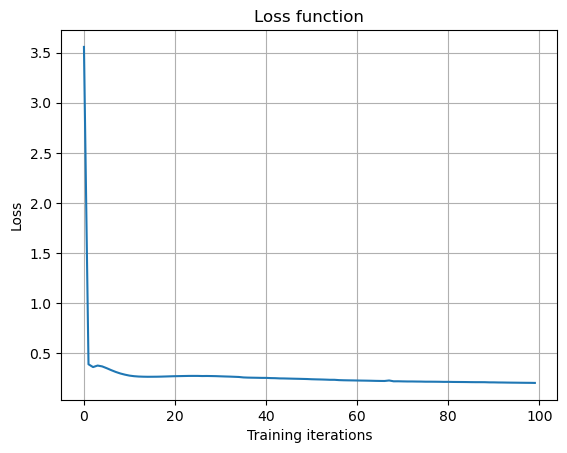

In [727]:
# loss function
x_line = range(epochs)
plt.plot(x_line, total_loss)
plt.title("Loss function")
plt.xlabel('Training iterations')
plt.ylabel('Loss')
plt.grid()
plt.show()

In [728]:
# make predictions
prediction = model(X_test).detach().numpy()
prediction = prediction.round() # round to either 0 or 1

In [729]:
prediction = prediction.squeeze(1)
prediction.shape

(114,)

In [730]:
# accuracy of predictions
n_correct = 0.0

for x, y in zip(prediction, y_test):

    if x == y:
        n_correct += 1

accuracy = (n_correct/len(y_test))*100
print(f'The model accuracy is {accuracy:.3f} %.')

The model accuracy is 90.351 %.


In [731]:
# save model
# torch.save(model.state_dict(), './cancer_classifier_model.pth')